# Introduction: Deep Neural Network

In this notebook we will develop a deep neural network to apply to the building energy prediction task. This is a supervised regression problem where the objective is build a model that is trained on past electricity consumption and weather information and then makes predictions for future energy consumption. 

Deep neural networks have gained immense popularity in recent years with extraordinary performance on many tasks. This includes above human level performance in computer vision - using convolutional neural networks - and natural language processing - using recurrent neural networks - problems. However, neural networks require a considerable amount of data points in order to learn the mapping from the features to the target, particularly as the depth of the network increases. For that reason, neural networks are typically not as succesful on small to medium sized datasets such as the building energy data used by EDIFES. The majority of the building datasets are under 1e6 observations, which may not be enough for a neural network to learn. Nonetheless, we will build a neural network that can then be tested on all of the buildings for performance relative to the other models.

As in previous notebooks, we will go through the implementation step-by-step, and then refactor the code into a single function. The end objective is a function that can take in the training features, training targets, testing features, and testing targets, and return the model performance. This can then be integrate into the previous develop `evaluate_models` function. After the addition of the deep neural network to the set of models, there will be eight models that can be run on hundreds of building datasets. 

### Imports 

We will use a standard stack of data science libraries: `pandas`, `numpy`, `sklearn`, `matplotlib` along with `keras` for the deep neural network implementation. See the `requirements.txt` file for the correct version of these libraries to install. 

In [1]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np

# Sklearn preprocessing functionality
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Matplotlib for visualizations
import matplotlib.pyplot as plt

# Adjust default font size 
plt.rcParams['font.size'] = 18

# Keras for neural networks
from keras import models, layers, optimizers, losses, metrics, callbacks

# Timer for recording runtime
from timeit import default_timer as timer

# Utilities developed for project
from utilities import preprocess_data

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/f-APS_weather.csv')
train, train_targets, test, test_targets = preprocess_data(df)

# Deep Neural Network

A fully-connected deep neural network is made up of many layers consisting of matrix multiplies and bias additions. The outputs of the matrix multiplies are passed through a non-linearity which is where the neural network gets its power to approximate any function (provided it has enough hidden units). Each layer is made up of a number of units (also called neurons), generally a multiple of 2. The number of neurons per layer and the number of layers determine the model capacity: a model with more layers and more neurons per layer will have greater capacity to learn. However, the more total neurons, the greater the chance the model will overfit to the training data, especially with a limited amount of training data. A general technique is to start with a shallow network (a few layers) and keep adding more layers until the model overfits. Then, either remove layers as needed or employ some form of model regularization. Choosing an architecture is the most critical part of the deep neural network modeling, and the ideal architecture depends on the problem. We are going to use the same neural network across all buildings even though the best model probably differs significantly from building to building. Optimizing neural network architectures automatically is an open research question, and applying a random search through model architectures might be one option although for this problem we will only use one architecture.

# Deep Neural Network Hyperparameters

There are many hyperparameters we need to choose for a deep neural network:

* Number of layers
* Number of units per layer
* Non-linear activation on hidden layers
* Regularization methods
* Optimizer (algorithm) used for minimizing the objective function
* Learning rate of the optimizer
* Number of training iterations
* Batch size

## Number of Layers

We will use a total of 7 layers: 1 input, 5 hidden, and 1 output layer. Generally, as the depth of the network increases, the model performs better on the training data because it has a greater capacity. To prevent overfitting though, we do not want to make the model too deep. 5 hidden layers was selected based on observing the training curves and validation scores of recorded by different models across several building datasets. More layers generally tended to not improve performance on the validation set, and fewer layers meant the model was not able to learn even the training data. 

## Units per Layer

The number of units per layers will be: 32, 64, 128, 256, 512, 1024, 1. The number of output units must be 1 because the network outputs a single prediction.

## Activations

The output layer in a regression problem must have no activation because we are interested in predicting a continous value that can take on any positive value (the output layer in a binary classification task has a `sigmoid` activation and the output layer for a multiclass classification task has a `softmax` activation).

The current recommedation for developing fully-connected deep neural networks is to use a ReLU (rectified linear) activation on the hidden layers along with Batch Normalization. The 
definition of the ReLU function is $$f(x) = max(0, x)$$. This activation prevents the vanishing gradient problem common with saturating activation functions such as `tanh` or `sigmoid`. ReLU is very quick to train and has demonstrated good accuracy. The drawbacks are that it can lead to "dead" neurons because any value less than 0 is set to 0. Moreover, the mean activation will be greater than 0, which can lead to issues with training stability. The mean activation issue can be addressed by applying a Batch Normalization layer after each activation. There are a number of other activation functions which have been developed in recent years, but ReLU + Batch Norm remains a good default choice with fast training times and reasonable generalization to the test data. 

## Regularization Methods

Regularization is used to address overfitting on the training data. This can be done by placing penalties on the L1 or L2 norm of the weight matrices that are added to the objective function. This encourages smaller magnitude weights which reduces the variance of the model. Other methods of regularization include data augmentation (typically for image data) or adding noise to the targets to encourage robustness to small perturbances. We will employ two methods of regularization: early stopping (discussion in the training iterations section below) and dropout. 

#### Dropout 

[Improving Neural Networks by Preventing Co-Adaptation of Feature Detectors](https://arxiv.org/pdf/1207.0580.pdf)

Dropout has become one of the most popular methods for regularization. It is a techique that randomly drops (sets the activations to 0) a fraction of the units in a layer during training. The fraction is usually around 0.5 and can be different across layers. The idea behind dropout is it encourages the model to be robust and have less variance because neurons in a subsequent layer cannot depend on the neuron output in the previous  layer. Dropout is applied to the outputs of fully connected hidden layers typically before the activation function. Dropout must not be used during testing! (Keras will handle this for us automatically). We will use dropout with a rate of 0.5 after every hidden layer except for the final hidden layer before the output. 

### Architecture Implementation

Below is the code to create the basic architecture described above. We use fully connected layers with "relu" activations for all of the hidden layers followed by dropout with a rate of 0.5 (except for the final hidden layer) and batch norm applied after every hidden layer. The final output layer has no activation because this is a regression problem.

In [3]:
model = models.Sequential()

# Input layer
model.add(layers.Dense(32, activation="relu", input_shape = (train.shape[1], )))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Five hidden layers
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation = "relu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation = "relu"))
model.add(layers.BatchNormalization())

# Output layer
model.add(layers.Dense(1, activation = None))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                704       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
__________

## Optimizer

All of the optimizers now used in neural networks are variants on vanilla gradient descent. For example, Nesterov momentum uses the concept of momentum based on exponentially decaying moving averages of past gradients to encourage stable training. Another family of optimizers, represented by AdaGrad, RMSProp, and Adam use adaptive learning rates to encourage faster training and better convergence. The currently recommended default optimizer is Adam (Adaptive Moment Estimation) which adaptively computes the learning rate for each individual parameter based of estimates of the first and second moments of the gradients. There are a number of hyperparamters associated with the Adam optimizer besides the learning rate, but these can usually be left at the defaults. 

### Learning Rate of the Optimizer

A learning rate that is too slow will take too long to converge, while a learning rate that is too high will not lead to the model "jumping" around the optimum of the objective function. While a good rule is to leave the learning rate low and train for a large number of epochs, training can go faster by starting with a higher learning rate and gradually decreasing it over the number of epochs. This is called learning rate decay.  

#### Learning Rate Decay

Learning rate decay gradually decreases the learning rate as the model trains. The idea is that the optimizer can take large steps at the beginning of training and then smaller steps as it gets closer to an optimum of the objective function. Learning rate decay is often linear or exponential. However, with the Adam optimization algorithm, the __learning rate is adaptively computed for individual parameters__. When using Adam, a learning rate decay schedule is typically not employed because of the adaptive learning rate. 

We will therefore use the Adam optimizer with the default parameters in Keras:

* `lr = 0.001`
* `beta_1 = 0.9`
* `beta_2 = 0.999`
* `epsilon = None`
* `decay = 0.0`
* `amsgrad = False` 

In [4]:
# Define the optimizer
opt = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999,
                      epsilon = None, decay = 0.0, amsgrad = False)

# Compile the model with specified optimizer
model.compile(optimizer = opt, loss = "mean_absolute_percentage_error",
              metrics = ["mean_absolute_percentage_error"])

## Number of Training Epochs

The number of training epochs is another crucial hyperparamter of a neural network. This represents the number of complete passes through the training data. Too few passes and the network will not learn the relationship, and too many passes and the network will overfit. Fortunately, there is a simple method to determine the best number of iterations that we have already employed when building a gradient boosting machine: early stopping.

### Early Stopping

Early stopping refers to training until the loss on a validation set does not decrease for a certain number of epochs. Early stopping is used to prevent overfitting by stopping training when the generalization error (as estimated by the validation set) has reached a minimum. We will implement early stopping by cutting off training after the validation loss has not decresed for 10 iterations. We will use 20% of the training data for validation (this will be randomly sampled from the data on every epoch). When implementing early stopping, we need to save the model parameters (weights and biases) every time the validation loss decreases. Then, when the training has stopped, we load the model weights that achieved the lowest error on the validation data. This model is then used to make precitions. Unfortunately this still requires writing the model weights to disk after every decrease in validation error which is not very efficient. Early stopping is always recommended as a simple method of regularization. The maximum number of epochs will be set at 100. 

## Batch Size 

The batch size refers to the number of training examples passed through the network at a time. All the neural network optimizers operate on minibatches of examples rather than processing the whole training set at once. Each batch is fed forward through the network, then backpropagation is used to calculate the gradients of the objective function with respect to the model parameters. Then the optimizer updates the weights according to the gradients and the learning rate. The next batch can then be passed through with the updated parameters. One pass of all the training data through the network is referred to as one epoch. Smaller batch sizes typically lead to better generalization performance although they may increase training time. Batch sizes are almost always a power of 2 to take advantage of computer architectures. We will use a batch size of 16 which means passing 16 training datapoints to the model at a time. The number of iterations per epoch will be (number of training datapoints - number of validation datapoints) / batch size.

### Training Implementation

We will train the model implementing the above description. The model uses early stopping with a patience of 10 epochs and 20% of the data used for validation. We save a copy of the model weights to disk every time the validation loss decreases. Training information will be available in the `history` variable.

In [5]:
# Early stopping and model checkpoint
callback_list = [callbacks.EarlyStopping(monitor = "val_loss", patience=10),
                 callbacks.ModelCheckpoint(filepath = "models/aps_model.h5",
                                           monitor = "val_loss",
                                           save_best_only = True,
                                           save_weights_only = True)]

# Train the model
history = model.fit(train, train_targets, batch_size = 32,
                    callbacks=callback_list, epochs = 100,
                    validation_split = 0.2)

Train on 71416 samples, validate on 17855 samples
Epoch 1/100
71416/71416 [==============================] - 50s 700us/step - loss: 33.5104 - mean_absolute_percentage_error: 33.5104 - val_loss: 33.9968 - val_mean_absolute_percentage_error: 33.9968
Epoch 2/100
71416/71416 [==============================] - 49s 680us/step - loss: 22.1322 - mean_absolute_percentage_error: 22.1322 - val_loss: 29.0347 - val_mean_absolute_percentage_error: 29.0347
Epoch 3/100
71416/71416 [==============================] - 47s 660us/step - loss: 20.2166 - mean_absolute_percentage_error: 20.2166 - val_loss: 68.6281 - val_mean_absolute_percentage_error: 68.6281
Epoch 4/100
71416/71416 [==============================] - 49s 686us/step - loss: 19.0316 - mean_absolute_percentage_error: 19.0316 - val_loss: 41.4244 - val_mean_absolute_percentage_error: 41.4244
Epoch 5/100
71416/71416 [==============================] - 48s 666us/step - loss: 18.6532 - mean_absolute_percentage_error: 18.6532 - val_loss: 79.8662 - val_

## Making Predictions 

To make predictions, we need to load in the best model weights (which we saved periodically during training). Then we simply called predict on the model.

In [6]:
# Load the model weights
model.load_weights('models/aps_model.h5')

# Make predictions on the test data
predictions = model.predict(test)

## Visualizing Training Curves

One diagnostic tool of a deep neural network model are the training curves. These show the training and validation error as the epochs progress. Training curves allow us to determine if the model is overfitting or if the validation error was still decreasing when training stopped. Based on this information, if the model was overfitting, we could add regularization or decrease the capacity of the model (fewer layers / fewer neurons per layer). If the validation loss was still decreasing at the end of training, then we would want to increase the number of training epochs. The training and validation losses are saved in the `history` variable. We can write a short function to visualize the training curves.

In [7]:
# Plot the training history of a keras model
def plot_history(history):
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    epochs = [int(i) for i in list(range(1, len(val_loss) + 1))]
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(epochs, train_loss, 'bo-', label = 'training loss')
    plt.plot(epochs, val_loss, 'ro-', label = 'validation loss')
    plt.xlabel('Epoch'); plt.ylabel('MAPE'); plt.title('Training Curves')
    plt.legend();
    plt.show()

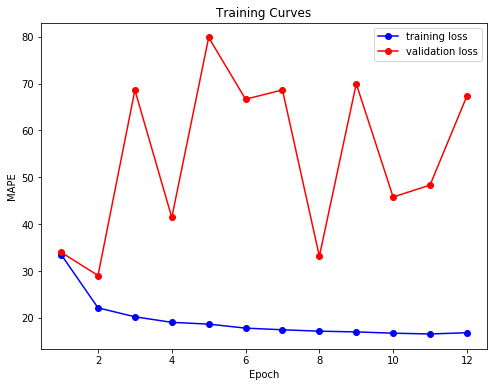

In [8]:
plot_history(history)

# Deep Neural Network Function

Now we can take the code and put it into a function. The function will take in the standard training features, training targets, testing features, testing targets and return the training time, prediction (inference) time, and the mape on the test data. 

In [9]:
def dnn_model(train, train_targets, test, test_targets, save_file):
    """Train a deep neural network and make predictions
    
    Parameters
    --------
    train : dataframe, shape = [n_training_samples, n_features]
        Set of training features for training a model
    
    train_targets : array, shape = [n_training_samples]
        Array of training targets for training a model
        
    test : dataframe, shape = [n_testing_samples, n_features]
        Set of testing features for making predictions with a model
    
    test_targets : array, shape = [n_testing_samples]
        Array of testing targets for evaluating the model predictions
        
    save_file : string
        File name for saving the model weights. The model will be saved
        to the directory models with the save file in the h5 format: models/save_file.h5
        
    Returns
    --------
    
    results : array, shape = [4]
        Numpy array of results. 
        First entry is the model, second is the training time,
        third is the testing time, and fourth is the MAPE. All entries
        are in strings and so will need to be converted to numbers.
    
    """
    model = models.Sequential()

    # Input layer
    model.add(layers.Dense(32, activation="relu", input_shape = (train.shape[1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())

    # Five hidden layers
    model.add(layers.Dense(64, activation = "relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation = "relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation = "relu"))
    model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Dense(1, activation = None))
    
    # Define the optimizer
    opt = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999,
                          epsilon = None, decay = 0.0, amsgrad = False)

    # Compile the model with specified optimizer
    model.compile(optimizer = opt, loss = "mean_absolute_percentage_error",
                  metrics = ["mean_absolute_percentage_error"])
    
    # Early stopping and model checkpoint
    callback_list = [callbacks.EarlyStopping(monitor = "val_loss", patience=10),
                     callbacks.ModelCheckpoint(filepath = "models/%s.h5" % save_file,
                                               monitor = "val_loss",
                                               save_best_only = True,
                                               save_weights_only = True)]

    # Start the training timer
    start = timer()
    # Train the model
    history = model.fit(train, train_targets, batch_size = 32,
                        callbacks=callback_list, epochs = 100,
                        validation_split = 0.2)
    
    # Calculate the training time
    end = timer()
    train_time = end - start
    
    # Load the best validation model weights
    model.load_weights('models/%s.h5' % save_file)

    # Start the testing time
    start = timer()
    # Make predictions on the test data
    predictions = model.predict(test)
    
    # Calculate the testing time
    end = timer()
    test_time = end - start
    
    # Calculate the mape
    mape = 100 * np.mean( abs(predictions - test_targets) / test_targets)
    
    return np.array(['dnn', train_time, test_time, mape])

## Interface with Other Models

The `dnn_model` function has the standard inputs and outputs for models we defined in the project. Therefore it can be easily integrated into the `evaluate_models` function with the six Scikit-Learn models and the Gradient Boosting Machine. This is the final model we will add to the retinue of models to evaluate on the EDIFES data. The next step will be running this function across hundreds of buildings and recording the results.

In [10]:
def evaluate_models(df):
    """Evaluate machine learning models
    on a building energy dataset. More models can be added
    to the function as required. 
    
    
    Parameters
    --------
    df : dataframe
        Building energy dataframe. Each row must have one observation
        and the columns must contain the features. The dataframe
        needs to have an "elec_cons" column to be used as targets. 
    
    Return
    --------
    results : dataframe, shape = [n_models, 4]
        Modeling metrics. A dataframe with columns:
        model, train_time, test_time, mape. Used for comparing
        models for a given building dataset
        
    """
    try:
        # Preprocess the data for machine learning
        train, train_targets, test, test_targets = preprocess_data(df, test_days = 183, scale = True)
    except Exception as e:
        print('Error processing data: ', e)
        return
        
    # elasticnet
    model = ElasticNet(alpha = 1.0, l1_ratio=0.5)
    elasticnet_results = implement_model(model, train, train_targets, test, 
                                         test_targets, model_name = 'elasticnet')
    
    # knn
    model = KNeighborsRegressor()
    knn_results = implement_model(model, train, train_targets, test, 
                                  test_targets, model_name = 'knn')
    
    # svm
    model = SVR()
    svm_results = implement_model(model, train, train_targets, test, 
                                   test_targets, model_name = 'svm')
    
    # rf
    model = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
    rf_results = implement_model(model, train, train_targets, test, 
                                  test_targets, model_name = 'rf')
    
    # et
    model = ExtraTreesRegressor(n_estimators=100, n_jobs = -1)
    et_results = implement_model(model, train, train_targets, test, 
                                  test_targets, model_name = 'et')
    
    # adaboost
    model = AdaBoostRegressor(n_estimators = 1000, learning_rate = 0.05, 
                              loss = 'exponential')
    adaboost_results = implement_model(model, train, train_targets, test, 
                                       test_targets, model_name = 'adaboost')
    
    # gbm
    gbm_results = gbm_model(train, train_targets, test, test_targets)
    
    dnn_results = dnn_model(train, train_targets, test, test_targets, save_file = 'dnn_model')
    
    # Put the results into a single array (stack the rows)
    results = np.vstack((elasticnet_results, knn_results, svm_results,
                         rf_results, et_results, adaboost_results,
                         gbm_results, dnn_results))
    
    # Convert the results to a dataframe
    results = pd.DataFrame(results, columns = ['model', 'train_time', 'test_time', 'mape'])
    
    # Convert the numeric results to numbers
    results.iloc[:, 1:] = results.iloc[:, 1:].astype(np.float32)
    
    return results

# Conclusions

In this notebook we built a deep neural network for use on the building prediction problem. We walked through the steps and the reasoning behind the design choices. The final model was then implemented in a function with the same set of standard inputs and outputs used throughout the project. We will now be able to use this function to evaluate all of the models on hundreds of buildings and choose the best model for further development. I will see you in the next notebook! 